## Notes on the 2D Poisson problem with stochastic LHS and RHS
*Connor Duffin*

Here we consider the stochastic Poisson problem:

\begin{gather*}
  -\nabla \cdot (\theta(x) \nabla u(x)) = 1 + \xi(x), \quad x \in \Omega \\
  u = 0, \quad x \in \partial \Omega
\end{gather*}

where $\Omega = [0, 1] \times [0, 1]$. We now set

* $\xi \sim \mathcal{GP}(0, \beta^2 I)$, with $\beta = 0.05$.
* $\log \theta \sim \mathcal{GP}\left(1 + 0.3 \sin(\pi(x_0 + x_1), \, k_{\mathrm{se}}(x, x')\right)$, $k_{\mathrm{se}} = \rho^2 \exp(-\lVert x - x' \rVert^2 / (2\ell^2))$, $\rho = 0.1$, $\ell = 0.2$.

Note that when we use a statFEM discretisation we arrive at the prior $p(u | \theta) = \mathcal{N}\left(A_\theta^{-1}b, A_\theta^{-1}G A_\theta^{-\top}\right)$, and in this note we consider preconditioned ULA schemes to sample from the joint $p(u, \theta)$, using the single-step update:

1. $\theta^{[k]} \sim p(\theta)$.
2. $u^{[k]} = u^{[k - 1]} - \eta M \nabla \phi_{\theta^{[k]}}(u^{[k - 1]}) + \sqrt{2 \eta M} Z^{[k]}$.

For $\nabla \phi_{\theta}(u) = A_{\theta}^\top G^{-1} \left(A_{\theta}u - b\right)$, and using the preconditioning matrix $M$ (positive semidefinite). 


We study various preconditioning methods, which use the mean-$\theta$ approximation of the covariance matrix $A_{\bar \theta}^{-1}G A_{\bar \theta}^{-\top}$. These methods are efficient as we know that the precision $A_{\bar \theta}^\top G^{-1} A_{\bar \theta}$ is sparse. In particular we demonstrate:

1. Sparse LU preconditioner: $M^{-1} = LU = A_{\bar \theta}^\top G^{-1} A_{\bar \theta}$.
2. Sparse incomplete-LU preconditioner $M^{-1} = LU \approx A_{\bar \theta}^\top G^{-1} A_{\bar \theta}$. Incomplete preconditioning uses an approximate factorization, that aims to ensure sparsity.
3. Algebraic multigrid preconditioner $M = A_{\bar \theta}^{-1} G A_{\bar \theta}^{-\top}$, where we solve $A_{\bar \theta}$ using an efficient algebraic multigrid (AMG) solver.
4. Low-rank preconditioner $M = \gamma I + Q_p \Lambda_p Q_p^\top$, for $Q_p$ an $n \times p$ matrix, and $\Lambda_p$ a $p \times p$ matrix.
5. TODO: sparse approximate inverse (diagonal) preconditioner.

All examples should be able to run on a laptop, but let me know if there are any problems :)

In [1]:
import fenics as fe
import numpy as np
import matplotlib.pyplot as plt

from sfmcmc.samplers import PoissonUnitTheta

np.random.seed(27)

Now we set up the simulation as we previously discuss above. Note that the option for $\theta$ to use the Kronecker GP  factorization leverages the Kronecker factorization of the covariance matrix, in order to efficiently generate samples.

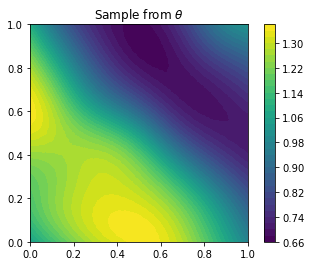

In [2]:
pois = PoissonUnitTheta(32)
pois.setup_G(sigma=0.05)
pois.setup_theta(0.2, 0.2, method="kronecker")
pois.sample_theta()

im = fe.plot(pois.theta)
plt.colorbar(im)
plt.title(r"Sample from $\theta$")
plt.savefig("../figures/theta-sample.png", dpi=300)
plt.show()

To give some intuition for the covariance, here is the spectrum:

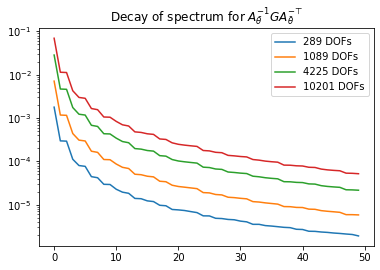

In [3]:
nx = [16, 32, 64, 100]
for n in nx:
    pois = PoissonUnitTheta(n)
    pois.setup_G(sigma=0.05)
    pois.setup_theta(0.1, 0.2)
    pois.setup_pc("lr")
    plt.plot(pois.M.vals[::-1], label=f"{(n + 1)**2} DOFs")

plt.yscale("log")
plt.title(r"Decay of spectrum for $A_{\bar\theta}^{-1} G A_{\bar \theta}^{-\top}$")
plt.legend()
plt.show()

Now we run the various samplers, on a $32 \times 32$ mesh, with stepsize $\eta = 0.1$:

In [4]:
pois = PoissonUnitTheta(32)
pois.setup_G(sigma=0.05)
pois.setup_theta(0.1, 0.2)

n_samples = 1000
eta = 1e-1

pois.setup_pc("lr", k=50, nugget=1e-10)
pois.u = np.zeros_like(pois.u)
samples_pc_lr = np.zeros((n_samples, pois.n_dofs))
for i in range(n_samples):
    pois.pula_step_lr(eta)
    samples_pc_lr[i, :] = pois.u

In [5]:
pois.setup_pc("lu")
pois.u = np.zeros_like(pois.u)
samples_pc_lu = np.zeros((n_samples, pois.n_dofs))
for i in range(n_samples):
    pois.pula_step_lu_mean(eta)
    samples_pc_lu[i, :] = pois.u

In [6]:
pois.setup_pc("ilu")
pois.u = np.zeros_like(pois.u)
samples_pc_ilu = np.zeros((n_samples, pois.n_dofs))

for i in range(n_samples):
    pois.pula_step_ilu_mean(eta)
    samples_pc_ilu[i, :] = pois.u

In [7]:
pois.setup_pc("amg")
pois.u = np.zeros_like(pois.u)
samples_pc_amg = np.zeros((n_samples, pois.n_dofs))
for i in range(n_samples):
    pois.pula_step_amg(eta)
    samples_pc_amg[i, :] = pois.u

In [8]:
samples_exact = np.zeros((n_samples, pois.n_dofs))
pois.u = np.zeros_like(pois.u)
for i in range(n_samples):
    samples_exact[i, :] = pois.exact_step()

Next, lets look at some visual checks of performance, starting with the traceplot:

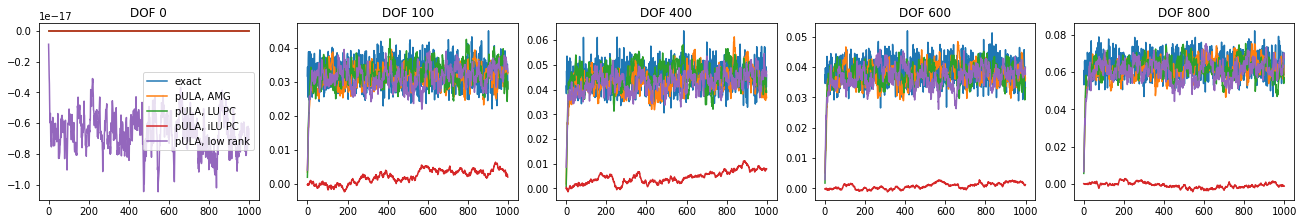

In [9]:
idx = [0, 100, 400, 600, 800]
fig, axs = plt.subplots(1, 5, constrained_layout=True, figsize=(18, 3))
for i, ix in enumerate(idx):
    axs[i].plot(samples_exact[:, ix], label="exact")
    axs[i].plot(samples_pc_amg[:, ix], label="pULA, AMG")
    axs[i].plot(samples_pc_lu[:, ix], label="pULA, LU PC")
    axs[i].plot(samples_pc_ilu[:, ix], label="pULA, iLU PC")
    axs[i].plot(samples_pc_lr[:, ix], label="pULA, low rank")

    axs[i].set_title(f"DOF {ix}")

axs[0].legend()
plt.show()

So we can see that all the preconditioners, apart from the iLU, seem to do a good job at getting into the right zone. In particular, the low-rank preconditioner seems to be as effective as the the full-rank in getting into the right spot.

Now, how do the pULA samples look in the mean? If we discard some warmup iterations then we get:

Rel. norm error for the mean: 4.21552e-02


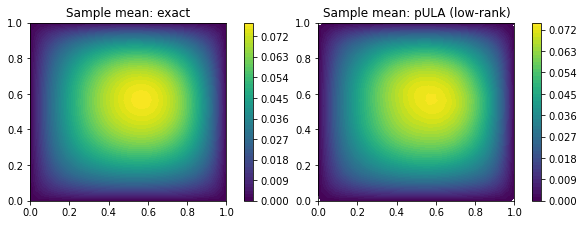

In [10]:
warmup = 100

mean_exact = np.mean(samples_exact[warmup:, :], axis=0)
mean_pula = np.mean(samples_pc_lr[warmup:, :], axis=0)

print("Rel. norm error for the mean: " +
      f"{np.linalg.norm(mean_exact - mean_pula) / np.linalg.norm(mean_exact):.5e}")

x0, x1 = pois.x_dofs[:, 0], pois.x_dofs[:, 1]
fig, axs = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True)
im = axs[0].tricontourf(x0, x1, mean_exact, 64)
plt.colorbar(im, ax=axs[0])
axs[0].set_title("Sample mean: exact")
im = axs[1].tricontourf(x0, x1, mean_pula, 64)
plt.colorbar(im, ax=axs[1])
axs[1].set_title("Sample mean: pULA (low-rank)")
plt.savefig("../figures/2d-means.png", dpi=300)
plt.show()

## Check the sampler runtimes

Now, let's check to see how fast each of the samplers are to run, on a laptop-scale example:

In [11]:
pois = PoissonUnitTheta(128)
pois.setup_G(sigma=0.05)
pois.setup_theta(0.1, 0.2, method="kronecker")

pois.setup_pc("lu")
%timeit pois.pula_step_lu_mean()
%timeit pois.pula_step_lu_mean(fixed_theta=True)

pois.setup_pc("ilu")
%timeit pois.pula_step_ilu_mean()
%timeit pois.pula_step_ilu_mean(fixed_theta=True)

pois.setup_pc("lr")
%timeit pois.pula_step_lr()
%timeit pois.pula_step_lr(fixed_theta=True)

%timeit pois.exact_step()

41 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.74 ms ± 237 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
39.8 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.01 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
39.4 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.24 ms ± 86.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
133 ms ± 2.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


So (on my machine), we see that all pULA samplers, when generating $\theta$, behave similarly across the board. The low-rank preconditioning is approximately twice as fast than the full-rank variant, so for very large problems this will likely need to be taken into account. Finally, we see that the exact sampler is approximately 4 times slower than a single step of each of the other samplers, and, if $\theta$ is not generated, it is approximately 30 times slower.